In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reload the CSV file after re-upload and display the first few rows
compas_data_reloaded = pd.read_csv('compas-scores-two-years.csv')
data=compas_data_reloaded
compas_data_reloaded.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Calculate summary statistics and recidivism rates for different racial groups
summary_stats = data.groupby('race')['decile_score'].agg(['mean', 'median', 'std']).reset_index()
recidivism_rates = data.groupby('race')['two_year_recid'].mean().reset_index()

(summary_stats, recidivism_rates)


(               race      mean  median       std
 0  African-American  5.368777     5.0  2.831122
 1             Asian  2.937500     2.0  2.601953
 2         Caucasian  3.735126     3.0  2.597926
 3          Hispanic  3.463108     3.0  2.599100
 4   Native American  6.166667     7.0  2.975389
 5             Other  2.949602     2.0  2.350895,
                race  two_year_recid
 0  African-American        0.514340
 1             Asian        0.281250
 2         Caucasian        0.393643
 3          Hispanic        0.364207
 4   Native American        0.555556
 5             Other        0.352785)

# Controling other variables the same, relation between score and race

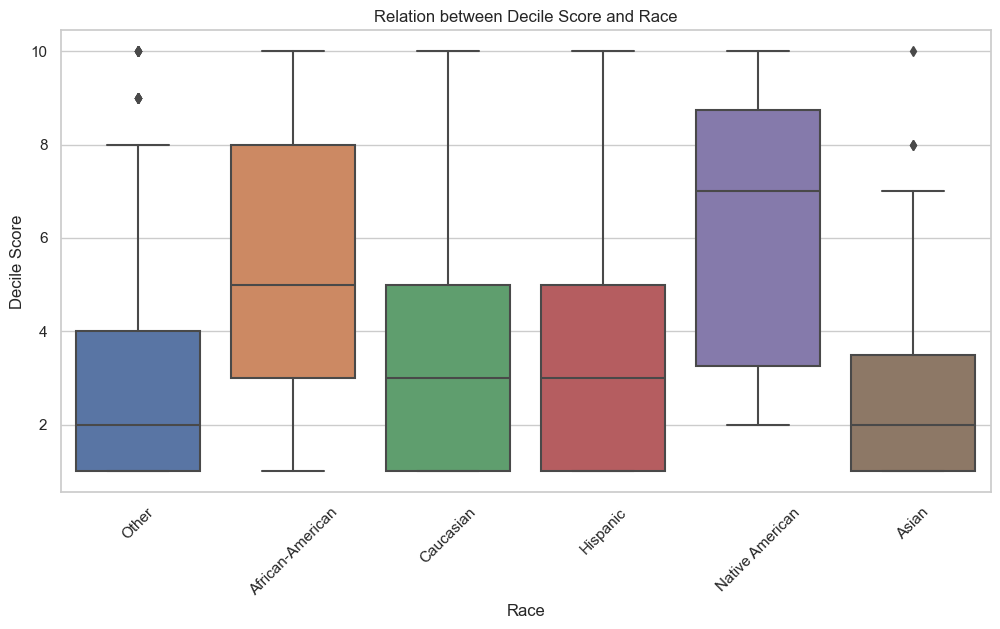

In [4]:
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating a boxplot to show the relationship between race and decile_score
plt.figure(figsize=(12, 6))
boxplot = sns.boxplot(x='race', y='decile_score', data=data)
plt.title('Relation between Decile Score and Race')
plt.xlabel('Race')
plt.ylabel('Decile Score')
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.show()


# Logistic regression

In [5]:
#Selecting Specific Columns:
#This line creates a new DataFrame df by selecting specific columns from the original data DataFrame. 
#These columns include demographic, charge, and incarceration details.
df = data[['age', 'c_charge_degree', 'race', 'score_text', 'priors_count',             
           #'decile_score',
           'two_year_recid', 'c_jail_in', 'c_jail_out', 'is_violent_recid']]


#Filtering for Specific Races:This line restricts the dataset to only include rows where the race is either 'African-American' or 'Caucasian'.
df = df.loc[df['race'].isin(('African-American', 'Caucasian'))]


#Encoding Racial Categories:
#Here, the race categories are converted into numeric values: 0 for 'African-American' and 1 for 'Caucasian'.
df.loc[df["race"] == "African-American", "race"] = 0
df.loc[df["race"] == "Caucasian", "race"] = 1

# Filtering Charge Degrees and Score Text:
#These lines exclude cases where the charge degree is 'O' (possibly other) and where the COMPAS score text is not available ('N/A').
df = df.loc[df['c_charge_degree'] != 'O']
df = df.loc[df['score_text'] != 'N/A']

#Calculating Length of Stay:
#This calculates the length of jail stay in days by subtracting the jail in-date from the jail out-date and converts the result into a number of days.
df['length_of_stay'] = (df['c_jail_out'].apply(pd.to_datetime) - df['c_jail_in'].apply(pd.to_datetime)).dt.days

#Cleaning Data:
#The first line removes any rows where length_of_stay is missing. 
#The second line removes the original jail in and out dates now that length_of_stay has been calculated.
df = df.dropna(subset = ['length_of_stay'])
df = df.drop(columns=['c_jail_in', 'c_jail_out'])

#Encoding Other Variables:
#This encodes the charge degree and COMPAS score text as numerical categories for easier analysis in statistical or machine learning models.
df = df.replace({'c_charge_degree': 'F'}, 0)
df = df.replace({'c_charge_degree': 'M'}, 1)
df = df.replace({'score_text': 'Low'}, 0)
df = df.replace({'score_text': 'Medium'}, 1)
df = df.replace({'score_text': 'High'}, 2)

#Removing Duplicates:
#This line removes duplicate rows, ensuring each entry in the DataFrame is unique.
df = df.drop_duplicates()

#Previewing the Data:
df.head()

,age,c_charge_degree,race,score_text,priors_count,two_year_recid,is_violent_recid,length_of_stay
1,34,0,0,0,0,1,1,10.0
2,24,0,0,0,4,1,0,1.0
6,41,0,1,1,14,1,0,6.0
8,39,1,1,0,0,0,0,2.0
9,21,0,1,0,1,1,1,0.0


In [6]:
#Importing the Train/Test Split Function:
from sklearn.model_selection import train_test_split

#Splitting the Dataset into Training and Remaining (Validation + Testing) Sets:
df_train, df_rem = train_test_split(df,train_size=5/7.0)
#Splitting the Remaining Data into Validation and Testing Sets:
df_valid, df_test = train_test_split(df_rem, test_size = 0.5)

The validation set is often used to fine-tune the model parameters and prevent overfitting before final evaluation on the test set.This approach of splitting into three parts helps in developing a robust model by having distinct datasets for training, tuning, and final evaluation.

In [7]:
#further subdivides the training, testing, and validation datasets into separate groups based on the race attribute. 
#Here, race has been encoded as 0 for 'African-American' and 1 for 'Caucasian'
df_train_a = df_train[df_train['race'] == 0]
df_train_c = df_train[df_train['race'] == 1]

df_test_a = df_test[df_test['race'] == 0]
df_test_c = df_test[df_test['race'] == 1]

df_valid_a = df_valid[df_valid['race'] == 0]
df_valid_c = df_valid[df_valid['race'] == 1]


By creating these subsets, you can analyze the data or train models specifically to investigate or address disparities in outcomes or model performances between these two racial groups. This approach is often used in fairness analyses or when creating models that need to be sensitive to the potential biases that might affect different demographic groups differently.

In [8]:
X_train_a = df_train_a.drop(columns = ['two_year_recid', 'race'])
X_train_c = df_train_c.drop(columns = ['two_year_recid', 'race'])
Y_train_a = df_train_a['two_year_recid']
Y_train_c = df_train_c['two_year_recid']
S_train_a = df_train_a['race']
S_train_c = df_train_c['race']

X_test_a = df_test_a.drop(columns = ['two_year_recid', 'race'])
X_test_c = df_test_c.drop(columns = ['two_year_recid', 'race'])
Y_test_a = df_test_a['two_year_recid']
Y_test_c = df_test_c['two_year_recid']
S_test_a = df_test_a['race']
S_test_c = df_test_c['race']

X_valid_a = df_valid_a.drop(columns = ['two_year_recid', 'race'])
X_valid_c = df_valid_c.drop(columns = ['two_year_recid', 'race'])
Y_valid_a = df_valid_a['two_year_recid']
Y_valid_c = df_valid_c['two_year_recid']
S_valid_a = df_valid_a['race']
S_valid_c = df_valid_c['race']

### Training Set Preparation
Features (X_train_a, X_train_c): These dataframes store the input features for each race by dropping the target variable two_year_recid and the sensitive attribute race. This ensures the models trained on these sets are not directly influenced by the race of the individuals


Targets (Y_train_a, Y_train_c): These are the target variables (labels) for the models, indicating whether the individual recidivated within two years


Sensitive Attributes (S_train_a, S_train_c): ): Although dropped from the features, you keep track of the sensitive attribute 'race' separately, possibly for analysis of model fairness or bias post-traini
oups.








### Testing Set Preparation
Features (X_test_a, X_test_c): Similar to the training sets, these feature sets are prepared by excluding the target and race variables.

Targets (Y_test_a, Y_test_c): These contain the actual outcomes used to evaluate model performance after training.

Sensitive Attributes (S_test_a, S_test_c): Retaining the sensitive attribute separately for potentially assessing any bias in model predictions during testing.



### Validation Set Preparation
Features (X_valid_a, X_valid_c): Prepared identically to the training and testing sets, these features are used to fine-tune the model parameters.

Targets (Y_valid_a, Y_valid_c): Used to validate the model's predictions and adjust for overfitting.

Sensitive Attributes (S_valid_a, S_valid_c): Kept for evaluating how the model's predictions might vary with the race of the individuals.



This structured approach allows you to conduct detailed analyses of model performance and fairness across different racial groups, a critical aspect when working with sensitive and potentially biased data. It enables the detection and mitigation of disparate impacts that the model might have on different subgroups.

In [9]:
import torch as t

train_X_c=t.tensor(np.array(X_train_c).astype('float32'))
train_Y_c=t.from_numpy(np.array(Y_train_c).astype('float32')).reshape(X_train_c.shape[0],1)
train_X_a=t.tensor(np.array(X_train_a).astype('float32'))
train_Y_a=t.from_numpy(np.array(Y_train_a).astype('float32')).reshape(X_train_a.shape[0],1)

valid_X_c=t.tensor(np.array(X_valid_c).astype('float32'))
valid_Y_c=t.from_numpy(np.array(Y_valid_c).astype('float32')).reshape(X_valid_c.shape[0],1)
valid_X_a=t.tensor(np.array(X_valid_a).astype('float32'))
valid_Y_a=t.from_numpy(np.array(Y_valid_a).astype('float32')).reshape(X_valid_a.shape[0],1)

test_X_c=t.tensor(np.array(X_test_c).astype('float32'))
test_Y_c=t.from_numpy(np.array(Y_test_c).astype('float32')).reshape(X_test_c.shape[0],1)
test_X_a=t.tensor(np.array(X_test_a).astype('float32'))
test_Y_a=t.from_numpy(np.array(Y_test_a).astype('float32')).reshape(X_test_a.shape[0],1)

Using PyTorch, a powerful deep learning framework, to convert your training, validation, and test datasets into tensors. These tensors are then used to train and evaluate deep learning models. Here’s a breakdown of what each line of the code does:architecture.

### Conversion to Tensors

Features (X):
 train_X_c, train_X_a, valid_X_c, valid_X_a, test_X_c, test_X_a: These lines convert the feature dataframes for Caucasian and African-American groups into PyTorch tensors of type float32. This conversion is essential for neural network models in PyTorch, as they operate on tensors.

Targets (Y):
 train_Y_c, train_Y_a, valid_Y_c, valid_Y_a, test_Y_c, test_Y_a: These lines convert the target arrays into PyTorch tensors and reshape them to have the shape [n_samples, 1], where n_samples is the number of samples in each respective set. This reshaping is typical for target variables in many machine learning tasks, particularly in supervised learning where the model predicts a single value per instance.



### Utilization in PyTorch

These tensors (train_X_c, train_Y_c, etc.) are now ready to be used in a machine learning model using PyTorch. For instance, they can be fed into a neural network for binary classification (predicting two_year_recid).

The use of float32 data type is aligned with the standard data type used in neural networks for efficiency and performance reasons.



### Next Steps

Model Definition: Define your neural network architecture using PyTorch's module system (nn.Module).

Training Loop: Implement the training loop where you will feed these tensors into your model, calculate the loss (e.g., using binary cross-entropy), and update the model's weights using an optimizer (e.g., Adam or SGD).

Evaluation: Use the validation and test sets to evaluate your model's performance and tune hyperparameters or make adjustments to the model architecture.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Output is 1 since it's binary classification

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))  # Sigmoid activation to output probabilities
        return y_pred


In [11]:
# Assuming input features have a certain size, replace with actual number of features
input_size = train_X_a.shape[1]  
model_a = LogisticRegressionModel(input_size)

# Loss function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

# Optimizer
optimizer = optim.SGD(model_a.parameters(), lr=0.01)  # Stochastic Gradient Descent


In [12]:
def train_model(model, criterion, optimizer, train_X, train_Y, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(train_X)  # Forward pass: compute the output class given a image
        loss = criterion(outputs, train_Y)  # Calculate loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update weights based on gradients

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the model
train_model(model_a, criterion, optimizer, train_X_a, train_Y_a.view(-1, 1))


Epoch [10/100], Loss: 1.8418
Epoch [20/100], Loss: 1.0667
Epoch [30/100], Loss: 1.0379
Epoch [40/100], Loss: 1.5384
Epoch [50/100], Loss: 1.0173
Epoch [60/100], Loss: 1.4431
Epoch [70/100], Loss: 1.0052
Epoch [80/100], Loss: 1.3540
Epoch [90/100], Loss: 1.0018
Epoch [100/100], Loss: 1.3457


In [13]:
def evaluate_model(model, X, Y):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted = model(X)
        predicted_classes = (predicted >= 0.5).float()  # Convert probabilities to 0 or 1
        correct_count = (predicted_classes == Y).sum().float()
        accuracy = correct_count / Y.shape[0]
        return accuracy

# Calculate accuracy on validation set
accuracy_a = evaluate_model(model_a, valid_X_a, valid_Y_a)
print(f'Accuracy of the model on the African-American validation group: {accuracy_a.item()*100:.2f}%')


Accuracy of the model on the African-American validation group: 67.21%


In [14]:
input_size = train_X_c.shape[1]
model_c = LogisticRegressionModel(input_size)

# Loss function
criterion_c = nn.BCELoss()

# Optimizer
optimizer_c = optim.SGD(model_c.parameters(), lr=0.01)


In [15]:
train_model(model_c, criterion_c, optimizer_c, train_X_c, train_Y_c.view(-1, 1))


Epoch [10/100], Loss: 1.6205
Epoch [20/100], Loss: 2.2805
Epoch [30/100], Loss: 1.2028
Epoch [40/100], Loss: 2.1240
Epoch [50/100], Loss: 1.1914
Epoch [60/100], Loss: 2.0982
Epoch [70/100], Loss: 1.1809
Epoch [80/100], Loss: 1.9164
Epoch [90/100], Loss: 1.1980
Epoch [100/100], Loss: 1.8980


In [16]:
accuracy_c = evaluate_model(model_c, valid_X_c, valid_Y_c)
print(f'Accuracy of the model on the Caucasian validation group: {accuracy_c.item()*100:.2f}%')


Accuracy of the model on the Caucasian validation group: 57.99%


In [17]:
# Accuracy in general and Calibration
accuracy = (accuracy_a+accuracy_c)/2
calibration = abs(accuracy_a - accuracy_c)

print("Validation accuracy: ", accuracy)
print("Validation calibration score: ", calibration)

Validation accuracy:  tensor(0.6260)
Validation calibration score:  tensor(0.0922)


In [18]:
# Assuming the models are PyTorch models named model_a and model_c

# Evaluate the model on the test set for African-American group
accuracy_a_test = evaluate_model(model_a, test_X_a, test_Y_a)
print(f'Test Accuracy for African-American group: {accuracy_a_test.item()*100:.2f}%')

# Evaluate the model on the test set for Caucasian group
accuracy_c_test = evaluate_model(model_c, test_X_c, test_Y_c)
print(f'Test Accuracy for Caucasian group: {accuracy_c_test.item()*100:.2f}%')

# Calculate average test accuracy and test calibration score
average_test_accuracy = (accuracy_a_test + accuracy_c_test) / 2
test_calibration_score = abs(accuracy_a_test - accuracy_c_test)
print(f"Average Test Accuracy: {average_test_accuracy.item()*100:.2f}%")
print(f"Test Calibration Score: {test_calibration_score.item()*100:.2f}%")


Test Accuracy for African-American group: 63.45%
Test Accuracy for Caucasian group: 57.34%
Average Test Accuracy: 60.40%
Test Calibration Score: 6.11%


In [28]:
def accuracy(Model_c, Model_a, df_c_X_train, df_c_y_train, df_a_X_train, df_a_y_train):
    yc_pred = (Model_c(df_c_X_train) >= 0.5)
    ya_pred = (Model_a(df_a_X_train) >= 0.5)
    accu_c = t.sum(yc_pred.flatten() == df_c_y_train.flatten()) / df_c_X_train.shape[0]
    accu_a = t.sum(ya_pred.flatten() == df_a_y_train.flatten()) / df_a_X_train.shape[0]

    accuracy = (accu_c + accu_a) / 2
    calibration = abs(accu_c - accu_a)

    print("Accuracy : {:.3f}%".format(accuracy.item() * 100))
    print("Calibration : {:.3f}%".format(calibration.item() * 100))

    return round(accuracy.item(), 4), round(calibration.item(), 4)


Function 'accuracy' is designed to calculate the accuracy and calibration scores of two PyTorch models, one trained on data from the Caucasian group (Model_c) and the other on data from the African-American group (Model_a). The function takes these models and their respective training datasets as inputs. Here's an analysis and a slight correction to improve the function:

### Function Breakdown
### Prediction:

yc_pred and ya_pred are tensors of booleans where predictions are determined by whether the model outputs are greater than or equal to 0.5. This is typical for binary classification tasks using logistic regression where the sigmoid function's output is interpreted as a probability.
### Accuracy Calculation:

accu_c and accu_a: These lines calculate the accuracy for each group by comparing the predicted labels to the true labels (df_c_y_train and df_a_y_train). The comparison generates a Boolean tensor, and taking the sum of this tensor gives the number of correct predictions. Dividing by the total number of samples (df_c_X_train.shape[0] or df_a_X_train.shape[0]) yields the accuracy as a proportion.
### Overall Accuracy and Calibration:

The average accuracy (accuracy) is calculated by averaging accu_c and accu_a.
Calibration (calibration) is computed as the absolute difference between accu_c and accu_a, which measures how similarly the two models perform across the different racial groups. This is an important metric in fairness analysis.
### Returning Results:

The function returns the rounded values of accuracy and calibration to four decimal places.
Suggested Correction and Improvement
The print statements at the end of your function will never execute because they are placed after a return statement. If you want these printouts to occur every time the function is called, you should move them before the return statement.

# Logistic Regression with Prejudice Regularizer

In [36]:
import torch as t
import torch.nn as nn

class PRLoss(nn.Module):  # Inherit from nn.Module
    def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta

    def forward(self, output_c, output_a):
        epsilon = 1e-8  # Small number to prevent division by zero or log(0)
        
        N_cau = t.tensor(output_c.shape[0], dtype=t.float32)
        N_aa = t.tensor(output_a.shape[0], dtype=t.float32)
        Dxisi = t.stack((N_aa, N_cau))  # Stack along a new dimension

        y_pred_cau = t.sum(output_c)
        y_pred_aa = t.sum(output_a)
        P_ys = t.stack((y_pred_aa, y_pred_cau)) / Dxisi

        total = t.cat((output_c, output_a), 0)
        P_y = t.sum(total) / (output_c.shape[0] + output_a.shape[0])

        P_s1y1 = t.log(P_ys[1] / (P_y + epsilon) + epsilon)
        P_s1y0 = t.log((1 - P_ys[1]) / (1 - P_y + epsilon) + epsilon)
        P_s0y1 = t.log(P_ys[0] / (P_y + epsilon) + epsilon)
        P_s0y0 = t.log((1 - P_ys[0]) / (1 - P_y + epsilon) + epsilon)

        PI_s1y1 = output_c * P_s1y1
        PI_s1y0 = (1 - output_c) * P_s1y0
        PI_s0y1 = output_a * P_s0y1
        PI_s0y0 = (1 - output_a) * P_s0y0

        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        return self.eta * PI


### Overview of the Class:
Initialization (__init__):

eta: A hyperparameter that scales the penalty.
Forward Method (forward):

Takes output_c and output_a as inputs, which represent model outputs for the Caucasian and African-American groups, respectively.
Implements equations to calculate the mutual information between the outputs and the sensitive attribute (race), aiming to penalize predictions that result in disparate impact.

In [37]:
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self,data):
        super(LogisticRegression, self).__init__()
        self.w = nn.Linear(data.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self, x):
        w = self.w(x)
        output = self.sigmod(w)
        return output

This class defines a simple logistic regression model using PyTorch’s neural network module (nn.Module)

### Class Overview
__init__ Method:

Initializes the model by setting up a linear layer with weights (self.w) and a bias. The input feature dimension is determined by data.shape[1], which should be the number of features in your dataset.
A sigmoid activation function (self.sigmod) is defined to map the linear layer's output to a probability (0 to 1), suitable for binary classification.


forward Method:

Defines the forward pass of the model. It takes an input tensor x, applies the linear transformation, and then applies the sigmoid function to produce the output.

In [42]:
class PRLR():
    def __init__(self, eta = 1, iters = 100, step = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.step = step
        self.iters = iters

    def fit(self, X_train_c, Y_train_c, X_train_a, Y_train_a, 
            X_valid_c, Y_valid_c, X_valid_a, Y_valid_a,
            X_test_c, Y_test_c, X_test_a, Y_test_a):
        modela = LogisticRegression(X_train_a)      # African-American
        modelc = LogisticRegression(X_train_c)      # Caucasian
        loss = nn.BCELoss(reduction='sum')
        iters = self.iters
        PI_term = PRLoss(eta = self.eta)
        #L2_optimizer = t.optim.Adam(list(np.abs(model0.parameters()) + np.abs(model1.parameters())), self.step, weight_decay = 1e-5)
        L2_optimizer = t.optim.Adam(list(modela.parameters())+list(modelc.parameters()), self.step, weight_decay = 1e-5)
        

        train_losses = []
        val_losses = []
        for iter in range(iters):
            modela.train()
            modelc.train()
            L2_optimizer.zero_grad()
            
            ## sigmoid probability and loss
            output_a = modela(X_train_a)    # A-A
            output_c = modelc(X_train_c)
            # Loss_func is the sum of LogLoss and PI Loss
            loss_function_train = loss(output_c, Y_train_c) + loss(output_a, Y_train_a) + PI_term.forward(output_c, output_a)
            loss_function_train.backward()
            L2_optimizer.step()
            train_losses.append(loss_function_train)


            output_a_valid = modela(X_valid_a)
            output_c_valid = modelc(X_valid_c)
            loss_function_val = loss(output_c_valid, Y_valid_c) + loss(output_a_valid, Y_valid_a) + PI_term.forward(output_c_valid, output_a_valid)

            val_losses.append(loss_function_val)


        modela.eval()
        modelc.eval()
        # accuracy
        accu = accuracy(modelc,modela,X_train_c,Y_train_c,X_train_a,Y_train_a)
        accu_val = accuracy(modelc,modela,X_valid_c,Y_valid_c,X_valid_a,Y_valid_a)
        accu_test = accuracy(modelc,modela,X_test_c,Y_test_c,X_test_a,Y_test_a)
        
        # PI index
        # pi_train = PI_term.forward(modela(X_train_a), modelc(X_train_c))
        # pi_valid = PI_term.forward(modela(X_valid_a), modelc(X_valid_c))
        # pi_test = PI_term.forward(modela(X_test_a), modelc(X_test_c))

        return accu, accu_val, accu_test

 class PRLR is designed to implement a specific logistic regression training process, considering both traditional loss and a custom probabilistic loss (PRLoss) that seems to be aimed at enforcing some kind of fairness or parity constraint between two different groups (African-American and Caucasian). 

### Class Overview
Initialization (__init__):

Initializes hyperparameters such as the learning rate (step), number of iterations (iters), and a scaling factor (et


a).
fit Method:

This method sets up and trains two logistic regression models—one for each group. It integrates a standard binary cross-entropy loss (BCELoss) and the custom PRLoss to enforce fairness constraints during training.ining.

In [43]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0]
accur = list()
accur_val = list()
accur_test = list()
# PI_train = list()
# PI_val = list()
# PI_test = list()
for i in range(0,len(eta_value)):
    #print("Theta Value: %d" % eta_value[e])
    PR = PRLR(eta = eta_value[i], iters = 3000, step = 0.01)
    accur_eta,accur_val_eta,accur_test_eta = PR.fit(train_X_c,train_Y_c,train_X_a,train_Y_a,
                                                    valid_X_c,valid_Y_c,valid_X_a,valid_Y_a,
                                                    test_X_c,test_Y_c,test_X_a,test_Y_a)
    accur.append(accur_eta)
    accur_val.append(accur_val_eta)
    accur_test.append(accur_test_eta)

Accuracy : 69.737%
Calibration : 0.946%
Accuracy : 72.892%
Calibration : 3.521%
Accuracy : 68.938%
Calibration : 4.082%
Accuracy : 69.370%
Calibration : 1.771%
Accuracy : 72.891%
Calibration : 0.747%
Accuracy : 69.977%
Calibration : 3.402%
Accuracy : 69.671%
Calibration : 1.807%
Accuracy : 71.966%
Calibration : 1.207%
Accuracy : 69.163%
Calibration : 2.234%
Accuracy : 69.646%
Calibration : 2.040%
Accuracy : 71.330%
Calibration : 0.396%
Accuracy : 68.993%
Calibration : 3.273%
Accuracy : 69.542%
Calibration : 1.974%
Accuracy : 71.041%
Calibration : 0.280%
Accuracy : 69.168%
Calibration : 3.623%
Accuracy : 69.449%
Calibration : 2.070%
Accuracy : 70.404%
Calibration : 0.531%
Accuracy : 68.708%
Calibration : 4.542%
Accuracy : 69.494%
Calibration : 2.161%
Accuracy : 70.693%
Calibration : 0.415%
Accuracy : 68.768%
Calibration : 5.122%
Accuracy : 69.348%
Calibration : 3.002%
Accuracy : 70.463%
Calibration : 1.435%
Accuracy : 68.638%
Calibration : 1.185%
Accuracy : 69.325%
Calibration : 2.956%


### Overview
eta_value: A list of different values for the eta parameter.
Training Loop:
For each eta value, you initialize a PRLR model and train it using the fit method.
The accuracies for training, validation, and test sets are stored in respective lists for later analysis.

In [33]:
#train
accur

[(0.6978, 0.0104),
 (0.6937, 0.0177),
 (0.6964, 0.0188),
 (0.6965, 0.0204),
 (0.6957, 0.0202),
 (0.6962, 0.0199),
 (0.6957, 0.0202),
 (0.6948, 0.0228),
 (0.6937, 0.0277),
 (0.695, 0.026)]

In [34]:
#validation
accur_val

[(0.7289, 0.0352),
 (0.7289, 0.0075),
 (0.7197, 0.0121),
 (0.7133, 0.004),
 (0.7087, 0.0007),
 (0.704, 0.0053),
 (0.7017, 0.0007),
 (0.7017, 0.0007),
 (0.7035, 0.0028),
 (0.7029, 0.003)]

In [35]:
#test
accur_test

[(0.6894, 0.0408),
 (0.6998, 0.034),
 (0.6934, 0.0258),
 (0.6899, 0.0327),
 (0.6894, 0.0408),
 (0.6871, 0.0454),
 (0.6882, 0.0431),
 (0.6865, 0.0396),
 (0.683, 0.0326),
 (0.6847, 0.0361)]

# Final Model

In [27]:
PR_eta2 = PRLR(eta = 2.0, iters = 3000, step = 0.01)
PR_eta2.fit(train_X_c,train_Y_c,train_X_a,train_Y_a,
                                                    valid_X_c,valid_Y_c,valid_X_a,valid_Y_a,
                                                    test_X_c,test_Y_c,test_X_a,test_Y_a)

((0.6967, 0.0181), (0.7197, 0.0121), (0.6916, 0.0223))

### Execution

Here’s what happens when you execute this code:

Model Initialization:

A new instance of PRLR is created with eta = 2.0, iters = 3000, and step = 0.01. These parameters will control the training process, where eta influences the weight of the fairness term in your loss function.
Model Training:

The fit method will be executed, which entails:
Training two logistic regression models for the two groups (Caucasian and African-American) over 3000 iterations.
Using a learning rate (step) of 0.01 to update the model parameters.
Applying both the binary cross-entropy loss and your custom PRLoss designed to adjust for fairness based on the eta value.
Return Values:

The method will return the training, validation, and testing accuracies. Make sure to capture these returned values if you want to analyze or report them.

# References

https://colab.research.google.com/github/sony/nnabla-examples/blob/master/interactive-demos/prejudice_remover_regularizer.ipynb#scrollTo=r45NcxtY6OzB